# Project 3: Wrangle and Analyze Data

In this project I will be wrangling and analyzing the tweet archive of Twitter use @dog_rates, also known as WeRateDogs. 

## Table of Contents
<ul>
<li><a href="#Gather">Gather</a></li>
<li><a href="#Assess">Assess</a></li>
<li><a href="#Clean">Clean</a></li>
<li><a href="#Store">Store</a></li>
<li><a href="#Visualize">Visualize</a></li>
</ul>

<a id='intro'></a>
## Gather

In [1]:
import json
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
from sqlalchemy import create_engine
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', -1)

### Import the WeRateDogs Twitter archive

In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### Import The tweet image predictions (programmatically)

In [3]:
# Download file from the url below:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [3]:
df_image_pred = pd.read_csv('image_predictions.tsv', delimiter='\t')
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Import Tweets using Tweepy library 

In [64]:
df_token = pd.read_csv('token.csv')
consumer_key = df_token.loc[0,'YOUR CONSUMER KEY']
consumer_secret = df_token.loc[0,'YOUR CONSUMER SECRET']
access_token = df_token.loc[0,'YOUR ACCESS TOKEN']
access_secret = df_token.loc[0,'YOUR ACCESS SECRET']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [61]:
#create the tweet_json.txt
error_ids = []


with open('tweet_json.txt', 'w') as file:
    for tweet_id in df_twitter_archive['tweet_id']:
        try:
            #query may take long so print ids to gauge time
            print(tweet_id)            
            tweets = api.get_status(tweet_id, tweet_mode='extended')
            
            #write JSON to a file. Convert Tweepy Status object into JSON
            #add ._json to fix the "not JSON serializable" error
            json.dump(tweets._json, file)
            #each tweet's JSON data on its own line
            file.write('\n')

        except Exception as e:
            print(str(tweet_id) + 'gives error:' + str(e))
            error_ids.append(tweet_id)



892420643555336193
892177421306343426
891815181378084864
891689557279858688
891327558926688256
891087950875897856
890971913173991426
890729181411237888
890609185150312448
890240255349198849
890006608113172480
889880896479866881
889665388333682689
889638837579907072
889531135344209921
889278841981685760
888917238123831296
888804989199671297
888554962724278272
888202515573088257
888202515573088257gives error:[{'code': 144, 'message': 'No status found with that ID.'}]
888078434458587136
887705289381826560
887517139158093824
887473957103951883
887343217045368832
887101392804085760
886983233522544640
886736880519319552
886680336477933568
886366144734445568
886267009285017600
886258384151887873
886054160059072513
885984800019947520
885528943205470208
885518971528720385
885311592912609280
885167619883638784
884925521741709313
884876753390489601
884562892145688576
884441805382717440
884247878851493888
884162670584377345
883838122936631299
883482846933004288
883360690899218434
88311783604608614

826848821049180160
826615380357632002
826598799820865537
826598365270007810
826476773533745153
826240494070030336
826204788643753985
826115272272650244
825876512159186944
825829644528148480
825535076884762624
825147591692263424
825120256414846976
825026590719483904
824796380199809024
824775126675836928
824663926340194305
824325613288833024
824297048279236611
824025158776213504
823939628516474880
823719002937630720
823699002998870016
823581115634085888
823333489516937216
823322678127919110
823269594223824897
822975315408461824
822872901745569793
822859134160621569
822647212903690241
822610361945911296
822489057087389700
822462944365645825
822244816520155136
822163064745328640
821886076407029760
821813639212650496
821765923262631936
821522889702862852
821421320206483457
821407182352777218
821153421864615936
821149554670182400
821107785811234820
821044531881721856
820837357901512704
820749716845686786
820690176645140481
820494788566847489
820446719150292993
820314633777061888
820078625395

771908950375665664
771770456517009408
771500966810099713
771380798096281600
771171053431250945
771136648247640064
771102124360998913
771014301343748096
771004394259247104
771004394259247104gives error:[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
770787852854652928
770772759874076672
770743923962707968
770743923962707968gives error:[{'code': 144, 'message': 'No status found with that ID.'}]
770655142660169732
770414278348247044
770293558247038976
770093767776997377
770069151037685760
769940425801170949
769695466921623552
769335591808995329
769212283578875904
768970937022709760
768909767477751808
768855141948723200
768609597686943744
768596291618299904
768554158521745409
768473857036525572
768193404517830656
767884188863397888
767754930266464257
767500508068192258
767191397493538821
767122157629476866
766864461642756096
766793450729734144
766714921925144576
766693177336135680
766423258543644672
766313316352462849
766078092750233600
766069199026450432
76

Rate limit reached. Sleeping for: 303


762035686371364864
761976711479193600
761750502866649088
761745352076779520
761672994376806400
761599872357261312
761371037149827077
761334018830917632
761292947749015552
761227390836215808
761004547850530816
760893934457552897
760656994973933572
760641137271070720
760539183865880579
760521673607086080
760290219849637889
760252756032651264
760190180481531904
760153949710192640
759943073749200896
759923798737051648
759846353224826880
759793422261743616
759566828574212096
759557299618865152
759447681597108224
759446261539934208
759197388317847553
759159934323924993
759099523532779520
759047813560868866
758854675097526272
758828659922702336
758740312047005698
758474966123810816
758467244762497024
758405701903519748
758355060040593408
758099635764359168
758041019896193024
757741869644341248
757729163776290825
757725642876129280
757611664640446465
757597904299253760
757596066325864448
757400162377592832
757393109802180609
757354760399941633
756998049151549440
756939218950160384
756651752796

680085611152338944
680070545539371008
680055455951884288
679877062409191424
679872969355714560
679862121895714818
679854723806179328
679844490799091713
679828447187857408
679777920601223168
679736210798047232
679729593985699840
679722016581222400
679530280114372609
679527802031484928
679511351870550016
679503373272485890
679475951516934144
679462823135686656
679405845277462528
679158373988876288
679148763231985668
679132435750195208
679111216690831360
679062614270468097
679047485189439488
679001094530465792
678991772295516161
678969228704284672
678800283649069056
678798276842360832
678774928607469569
678767140346941444
678764513869611008
678755239630127104
678740035362037760
678708137298427904
678675843183484930
678643457146150913
678446151570427904
678424312106393600
678410210315247616
678399652199309312


Rate limit reached. Sleeping for: 732


678399652199309312gives error:Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
678396796259975168
678389028614488064
678380236862578688
678341075375947776
678334497360859136
678278586130948096
678255464182861824
678023323247357953
678021115718029313
677961670166224897
677918531514703872
677895101218201600
677716515794329600
677700003327029250
677698403548192770
677687604918272002
677673981332312066
677662372920729601
677644091929329666
677573743309385728
677565715327688705
677557565589463040
677547928504967168
677530072887205888
677335745548390400
677334615166730240
677331501395156992
677328882937298944
677314812125323265
677301033169788928
677269281705472000
677228873407442944
677187300187611136
676975532580409345
676957860086095872
676949632774234114
676948236477857792
676946864479084545
676942428000112642
676936541936185344
676916996760600576
676897532954456065
67686450161

668960084974809088
668955713004314625
668932921458302977
668902994700836864
668892474547511297
668872652652679168
668852170888998912
668826086256599040
668815180734689280
668779399630725120
668655139528511488
668645506898350081
668643542311546881
668641109086707712
668636665813057536
668633411083464705
668631377374486528
668627278264475648
668625577880875008
668623201287675904
668620235289837568
668614819948453888
668587383441514497
668567822092664832
668544745690562560
668542336805281792
668537837512433665
668528771708952576
668507509523615744
668496999348633600
668484198282485761
668480044826800133
668466899341221888
668297328638447616
668291999406125056
668286279830867968
668274247790391296
668268907921326080
668256321989451776
668248472370458624
668237644992782336
668226093875376128
668221241640230912
668204964695683073
668190681446379520
668171859951755264
668154635664932864
668142349051129856
668113020489474048
667937095915278337
667924896115245057
667915453470232577
667911425562

In [4]:
#Use pd.read_json to read JSON data. It is much easier compared to "json.dump"

df_twitter_data = pd.read_json('tweet_json.txt', lines=True)
df_twitter_data.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}",38354,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,...,NaN,NaN,NaN,NaN,8422,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': '⇩ merch ⇩ DM YOUR DOGS', 'description': 'Your Only Source For Professional Dog Ratings ⠀ ⠀IG, FB, Snapchat ⇨ WeRateDogs ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ Business: dogratingtwitter@gmail.com', 'url': 'https://t.co/N7sNNHAEXS', 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHAEXS', 'expanded_url': 'http://weratedogs.com', 'display_url': 'weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 7307710, 'friends_count': 10, 'listed_count': 5206, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 138447, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 8938, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1046964996876439552/IyFLityY_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1046964996876439552/IyFLityY_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/4196983835/1538511095', 'profile_link_color': 'F5ABB5', 'profile_sidebar_border_color': '000000', 'profile_sidebar_fill_color': '000000', 'profile_text_color': '000000', 'profile_use_background_image': False, 'has_extended_profile': False, 'default_profile': False, 'default_profile_image': False, 'following': False, 'follow_request_sent': False, 'notifications': False, 'translator_type': 'none'}"
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu

In [5]:
df_twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2340 non-null datetime64[ns]
display_text_range               2340 non-null object
entities                         2340 non-null object
extended_entities                2066 non-null object
favorite_count                   2340 non-null int64
favorited                        2340 non-null bool
full_text                        2340 non-null object
geo                              0 non-null float64
id                               2340 non-null int64
id_str                           2340 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

<a id='Assess'></a>
## Assess

In [7]:
df_twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1115,732726085725589504,NaN,NaN,2016-05-18 00:14:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Aldrick. He looks wise af. Also except...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/732726085...,11,10,Aldrick,None,None,None,None
2312,666776908487630848,NaN,NaN,2015-11-18 00:36:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Josep. He is a Rye Manganese mix. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,None,None,None,None
216,850753642995093505,NaN,NaN,2017-04-08 16:54:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Kyle. He made a joke about your shoes,...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/850753642...,11,10,Kyle,None,None,None,None
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
847,766078092750233600,NaN,NaN,2016-08-18 01:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Colby. He's currently r...,7.258423e+17,4.196984e+09,2016-04-29 00:21:01 +0000,https://twitter.com/dog_rates/status/725842289...,12,10,Colby,None,None,None,None


In [9]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
df_twitter_archive[df_twitter_archive.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [13]:
df_twitter_archive.in_reply_to_status_id.unique()

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.56286004e+17, 8.55861584e+17, 8.55858536e+17,
       8.50328819e+17, 8.48212112e+17, 8.47606176e+17, 7.59099524e+17,
       8.40698300e+17, 8.38145499e+17, 8.38085539e+17, 8.35245984e+17,
       8.32087548e+17, 8.31903044e+17, 8.26598365e+17, 8.23326389e+17,
       8.21152593e+17, 8.13127252e+17, 8.11627233e+17, 7.33109485e+17,
       8.01854331e+17, 8.00857954e+17, 7.97123751e+17, 7.72743019e+17,
       7.66711819e+17, 7.63865175e+17, 7.50180499e+17, 7.47648654e+17,
       7.46885919e+17, 6.91416866e+17, 7.38411920e+17, 7.29113531e+17,
       7.07980066e+17, 7.03255936e+17, 7.04485745e+17, 7.03041950e+17,
       6.96488711e+17, 6.75349384e+17, 6.70668383e+17, 6.93642232e+17,
       6.93572216e+17, 6.92417313e+17, 6.92041935e+17, 6.90341254e+17,
       6.86034025e+17, 6.85547936e+17, 6.84959799e+17, 6.84481075e+17,
      

In [14]:
df_twitter_archive.retweeted_status_id.unique()

array([           nan, 8.87473957e+17, 8.86053734e+17, 8.30583321e+17,
       8.78057613e+17, 8.78281511e+17, 6.69000397e+17, 8.76850772e+17,
       8.66334965e+17, 8.68880398e+17, 8.73213776e+17, 8.72657584e+17,
       8.41077006e+17, 8.59196979e+17, 8.68552279e+17, 8.65013420e+17,
       8.66450706e+17, 8.37820168e+17, 8.63062472e+17, 8.06629075e+17,
       8.60563773e+17, 8.60914485e+17, 7.61672994e+17, 8.39549326e+17,
       8.57061112e+17, 8.44704788e+17, 8.56330159e+17, 8.42163533e+17,
       8.55122533e+17, 8.31650052e+17, 8.29374342e+17, 8.48289382e+17,
       8.33124695e+17, 8.32369877e+17, 8.47971000e+17, 7.56288534e+17,
       7.73308824e+17, 8.07106841e+17, 8.17423860e+17, 8.40632337e+17,
       6.67152164e+17, 8.39289919e+17, 8.38905981e+17, 7.83839966e+17,
       8.20749717e+17, 8.37011345e+17, 8.36648149e+17, 8.17827839e+17,
       7.86963064e+17, 8.35264099e+17, 7.53039831e+17, 8.29501995e+17,
       8.32434358e+17, 8.32766382e+17, 7.86709083e+17, 7.93286476e+17,
      

In [15]:
df_twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Lola          10
Penny         10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
Buddy          7
an             7
Bailey         7
Daisy          7
Toby           7
Oscar          6
Koda           6
Stanley        6
Milo           6
Rusty          6
Jack           6
Dave           6
Scout          6
Bella          6
Jax            6
Leo            6
George         5
            ... 
Bobbay         1
Kody           1
Smiley         1
Chevy          1
Wafer          1
Tom            1
Grady          1
Chuq           1
Diogi          1
Grizzwald      1
Derby          1
Barney         1
Koko           1
Siba           1
Carper         1
Jameson        1
Pinot          1
Odin           1
Heinrich       1
Bodie          1
Comet          1
Mutt           1
Timber         1
Tonks          1
Buddah         1
Strudel        1
Karl           1
Cilantro      

In [16]:
df_image_pred.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
df_image_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
906,700167517596164096,https://pbs.twimg.com/media/Cbd-o8hWwAE4OFm.jpg,1,beagle,0.162585,True,Pembroke,0.120481,True,Siberian_husky,0.110284,True
560,677716515794329600,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,teddy,0.662908,False,crib,0.031891,False,chow,0.025438,True
596,679527802031484928,https://pbs.twimg.com/media/CW4q7jDWkAA2y8g.jpg,1,mailbox,0.336393,False,cannon,0.158936,False,cuirass,0.052647,False
1373,762471784394268675,https://pbs.twimg.com/ext_tw_video_thumb/76247...,1,Samoyed,0.540276,True,standard_poodle,0.279802,True,toy_poodle,0.102058,True
972,706644897839910912,https://pbs.twimg.com/ext_tw_video_thumb/70664...,1,space_heater,0.137871,False,Chihuahua,0.132928,True,cougar,0.113866,False


In [18]:
df_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
df_image_pred.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
web_site                      19
Eskimo_dog                    18
Shetland_sheepdog             18
beagle                        18
teddy                         18
Maltese_dog                   18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [21]:
df_image_pred.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Pembroke                           27
collie                             27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
miniature_pinscher                 20
malinois                           20
toy_terrier                        20
Samoyed                            20
chow                               20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [22]:
df_image_pred.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
toy_poodle                        29
Pekinese                          29
Pomeranian                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
b

In [23]:
df_twitter_data.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",38354,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,8422,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",32869,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,6207,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",24757,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,4107,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",41696,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,8538,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",39873,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,NaN,9275,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [24]:
df_twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2340 non-null datetime64[ns]
display_text_range               2340 non-null object
entities                         2340 non-null object
extended_entities                2066 non-null object
favorite_count                   2340 non-null int64
favorited                        2340 non-null bool
full_text                        2340 non-null object
geo                              0 non-null float64
id                               2340 non-null int64
id_str                           2340 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

#### Quality
##### `df_twitter_archive` table
- "tweet_id" is an int but not a string
- The non-null values in columns "in_reply_to_status_id" and "retweeted_status_id" mean there are retweets. We only want the original ratings
- "timestamp" is string but not a datetime
- Missing some values in "expanded_urls"
- The minimum value of rating_denominator is 0. Should always be 10 or Nan
- Inaccurate name (None, a) in "name" column


##### `df_image_pred` table
- 'tweet_id' is an int but not a string
- There are only 2075 rows in this table. `df_twitter_archive` has 2356 records
- p1, p2, p3 predictions’ cases are inconsistent. Not all of them are lowercase


##### `df_twitter_data` table
- We only need columns "id", "favorite_count" and "retweet_count"
- "id" is an int but shoud be string
- "id" should be "tweet_id" so the column name is consistent with the other 2 tables
- There are only 2340 rows in this table. `df_twitter_archive` has 2356 records

#### Tidiness
- Columns doggo, floofer, pupper, and puppo in `df_twitter_archive` table should be combined into 1 column as this is one variable that identify stage of dog.
- All 3 tables should be merged into 1 table as they are all information about same type of observational unit (tweets).


<a id='Assess'></a>
## Clean

In [6]:
#make a copy of all 3 tables
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_pred_clean = df_image_pred.copy()
df_twitter_data_clean = df_twitter_data.copy()

##### `df_twitter_archive` table
- "tweet_id" is an int but not a string
- "timestamp" is string but not a datetime

##### `df_image_pred` table
- 'tweet_id' is an int but not a string

##### `df_twitter_data` table
- We only need columns "id", "favorite_count" and "retweet_count"
- "id" is an int but shoud be string
- "id" should be "tweet_id" so the column name is consistent with the other 2 tables

##### Define
- In `df_twitter_archive` table, change "tweet_id" type to string, "timestamp" to datetime
- In `df_image_pred` table, change "tweet_id" type to string
- In `df_twitter_data` table, keep only columns "id", "favorite_count" and "retweet_count"
- In `df_twitter_data` table, change "id" type to string; rename it to "tweet_id". Change the type to string

In [7]:
df_twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

##### Code

In [8]:
df_twitter_archive_clean.tweet_id = df_twitter_archive.tweet_id.astype(str)
df_image_pred_clean.tweet_id = df_image_pred.tweet_id.astype(str)
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive.timestamp)
df_twitter_data_clean = df_twitter_data[['id', 'favorite_count', 'retweet_count']]

In [9]:
df_twitter_data_clean = df_twitter_data_clean.rename(columns={'id': 'tweet_id'})

In [10]:
df_twitter_data_clean.tweet_id = df_twitter_data_clean.tweet_id.astype(str)

##### Test

In [11]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

In [12]:
df_image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [13]:
df_twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null object
favorite_count    2340 non-null int64
retweet_count     2340 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


***

##### `df_twitter_archive` table
- The non-null values in columns "in_reply_to_status_id" and "retweeted_status_id" mean there are retweets. We only want the original ratings

##### Define
- in `df_twitter_archive` table, remove the retweets rows 

##### Code

In [14]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.in_reply_to_status_id.isnull()]

In [15]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

##### Test

In [16]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), floa

***

##### `df_twitter_archive` table
- Missing some values in "expanded_urls"

##### Define
- in `df_twitter_archive` table, add the missing urls based on tweet_id

##### Code

In [17]:
# Check the url format

df_twitter_archive_clean['expanded_urls'][0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [18]:
# Create a function so it can be applied to each row in 'expanded_urls'

def create_url(table):
    if pd.isnull(table['expanded_urls']):
        url = 'https://twitter.com/dog_rates/status/'+table['tweet_id']+'/photo/1'
        return url    
    else:
        return table['expanded_urls']

In [19]:
df_twitter_archive_clean['expanded_urls'] = df_twitter_archive_clean.apply(create_url, axis=1)

##### Test

In [20]:
df_twitter_archive_clean[df_twitter_archive_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [21]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2097 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), floa

*** 

##### `df_twitter_archive` table
- The minimum value of rating_denominator is 0. Should always be 10 or NaN

##### Define
- in `df_twitter_archive` table, drop the row if the rating_denominator is neither 10 or NaN

##### Code

In [22]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator == 10]

##### Test

In [23]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


***

##### `df_twitter_archive` table
- Inaccurate name (None, a) in "name" column

##### Define
- in `df_twitter_archive` table, replace the inaccurate name with NaN

##### Code

In [24]:
# Review all the names need to be replaced
def fix_name(table):
    if table['name'][0].islower():
        print(table['name'])
    elif table['name'] == 'None':
        print(table['name'])
    else:
        pass

df_twitter_archive_clean.apply(fix_name, axis=1)

None
None
None
such
None
None
None
None
None
None
None
a
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
quite
None
None
None
None
None
None
quite
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
not
None
None
None
one
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
incredibly
None
None
None
None
None
None
None
None
None
None
None
None
a
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
a
None
None
None
very
None
my
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
one
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
not
None
his
one
None
None
None
None
None
None
a
a
None
None
None
None
a
None
None
an
very
None


0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
31      None
        ... 
2325    None
2326    None
2327    None
2328    None
2329    None
2330    None
2331    None
2332    None
2333    None
2334    None
2336    None
2337    None
2338    None
2339    None
2340    None
2341    None
2342    None
2343    None
2344    None
2345    None
2346    None
2347    None
2348    None
2349    None
2350    None
2351    None
2352    None
2353    None
2354    None
2355    None
Length: 2080, dtype: object

In [25]:
# Repalce the inaccurate names with NaN

def fix_name(table):
    if table['name'][0].islower():
        return np.nan
    elif table['name'] == 'None':
        return np.nan
    else:
        return table['name']

df_twitter_archive_clean['name'] = df_twitter_archive_clean.apply(fix_name, axis=1)

##### Test

In [26]:
df_twitter_archive_clean.name.value_counts()

Lucy         11
Charlie      11
Oliver       10
Cooper       10
Penny        9 
Tucker       9 
Winston      8 
Lola         8 
Sadie        8 
Toby         7 
Daisy        7 
Jax          6 
Stanley      6 
Koda         6 
Bailey       6 
Bo           6 
Bella        6 
Oscar        6 
Louis        5 
Bentley      5 
Chester      5 
Buddy        5 
Scout        5 
Rusty        5 
Leo          5 
Dave         5 
Milo         5 
Jerry        4 
Boomer       4 
Reggie       4 
            .. 
Remus        1 
Jonah        1 
Aqua         1 
Dale         1 
Tuck         1 
Ricky        1 
Sweet        1 
Grey         1 
Bauer        1 
Ember        1 
Henry        1 
Kayla        1 
Erik         1 
Livvie       1 
Perry        1 
Reptar       1 
Tiger        1 
Bookstore    1 
Fiji         1 
Sierra       1 
Colin        1 
Snoopy       1 
Jameson      1 
Clyde        1 
Ronduh       1 
Brandi       1 
Ole          1 
Walker       1 
Halo         1 
Ferg         1 
Name: name, Length: 927,

***

##### `df_image_pred ` table
- p1, p2, p3 predictions’ cases are inconsistent. Not all of them are lowercase

##### Define
- in `df_image_pred` table, change p1, p2, p3 predictions to lowercase

##### Code

In [27]:
df_image_pred_clean['p1'] = df_image_pred_clean['p1'].str.lower()
df_image_pred_clean['p2'] = df_image_pred_clean['p2'].str.lower()
df_image_pred_clean['p3'] = df_image_pred_clean['p3'].str.lower()

##### Test

In [28]:
df_image_pred_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese_mountain_dog,0.651137,True,english_springer,0.263788,True,greater_swiss_mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


***

##### `df_twitter_archive ` table
- Columns doggo, floofer, pupper, and puppo should be combined into 1 column as this is one variable that identify stage of dog

##### Define
- Combine doggo, floofer, pupper, and puppo columns to a new column called stage

##### Code

In [29]:
#pd.melt() will create many unnecessary rows. Create a function to combine these 4 columns
def create_stage(table):
    if table.doggo=='doggo':
        return 'doggo'
    elif table.floofer=='floofer':
        return 'floofer'
    elif table.pupper=='pupper':
        return 'pupper'
    elif table.puppo=='puppo':
        return 'puppo'
    else:
        return 'None'

In [30]:
df_twitter_archive_clean['stage'] = df_twitter_archive_clean.apply(create_stage, axis=1)

##### Test

In [31]:
df_twitter_archive_clean[['stage','doggo', 'floofer', 'pupper', 'puppo']].head()

,stage,doggo,floofer,pupper,puppo
0,None,None,None,None,None
1,None,None,None,None,None
2,None,None,None,None,None
3,None,None,None,None,None
4,None,None,None,None,None


In [32]:
df_twitter_archive_clean.sort_values('doggo', ascending=False)[['stage','doggo', 'floofer', 'pupper', 'puppo']].head()

,stage,doggo,floofer,pupper,puppo
899,doggo,doggo,None,None,None
1079,doggo,doggo,None,None,None
616,doggo,doggo,None,None,None
1204,doggo,doggo,None,None,None
956,doggo,doggo,None,pupper,None


In [33]:
df_twitter_archive_clean.sort_values('floofer', ascending=False)[['stage','doggo', 'floofer', 'pupper', 'puppo']].head()

,stage,doggo,floofer,pupper,puppo
774,floofer,None,floofer,None,None
582,floofer,None,floofer,None,None
1110,floofer,None,floofer,None,None
1022,floofer,None,floofer,None,None
1091,floofer,None,floofer,None,None


In [34]:
df_twitter_archive_clean.sort_values('pupper', ascending=False)[['stage','doggo', 'floofer', 'pupper', 'puppo']].head()

,stage,doggo,floofer,pupper,puppo
1571,pupper,None,None,pupper,None
418,pupper,None,None,pupper,None
444,pupper,None,None,pupper,None
973,pupper,None,None,pupper,None
1617,pupper,None,None,pupper,None


In [35]:
df_twitter_archive_clean.sort_values('puppo', ascending=False)[['stage','doggo', 'floofer', 'pupper', 'puppo']].head()

,stage,doggo,floofer,pupper,puppo
413,puppo,None,None,None,puppo
191,doggo,doggo,None,None,puppo
395,puppo,None,None,None,puppo
554,puppo,None,None,None,puppo
1048,puppo,None,None,None,puppo


***

##### `df_twitter_archive ` table
- All 3 tables should be merged into 1 table

##### Define
- Merge all 3 tables to `df_clean` table

##### Code

In [36]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2080 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2080 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          1387 non-null object
doggo                         2080 non-null object
floofer                       2080 non-null object
pupper                        2080 non-null object
puppo                         2080 non-null object
stage                         2

In [37]:
df_image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [38]:
df_twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null object
favorite_count    2340 non-null int64
retweet_count     2340 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


In [39]:
df_clean = pd.merge(df_twitter_archive_clean, df_image_pred_clean, on='tweet_id', how='left')
df_clean = pd.merge(df_clean, df_twitter_data_clean, on='tweet_id', how='left')

In [40]:
# Drop the not useful columns in df_clean for this project

df_clean =df_clean[['tweet_id', 'timestamp', 'text', 'expanded_urls', 'stage', 'rating_numerator', 'rating_denominator',
                    'name', 'jpg_url','p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 
                   'favorite_count', 'retweet_count']]

In [41]:
df_clean = df_clean[~df_clean.retweet_count.isnull()]

##### Test

In [42]:
df_clean.head()

,tweet_id,timestamp,text,expanded_urls,stage,rating_numerator,rating_denominator,name,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,None,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,38354.0,8422.0
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,None,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,32869.0,6207.0
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,None,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,24757.0,4107.0
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,None,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,41696.0,8538.0
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",None,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,39873.0,9275.0


In [43]:
df_clean.retweet_count.isnull().any(), df_clean.favorite_count.isnull().any()

(False, False)

<a id='Store'></a>
## Store

In [44]:
# Save to csv file
df_clean.to_csv('twitter_archive_master.csv',index=False)

In [45]:
# Save to database

engine = create_engine('sqlite:///twitter_archive_master.db')

df_clean.to_sql('twitter_dog', engine, index=False)

<a id='Visualize'></a>
## Visualize

We first will take a look at the algorithm's #1 prediction's recall.

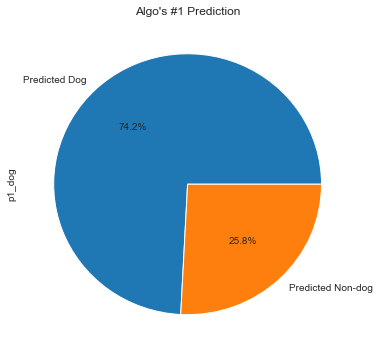

In [46]:
plt.figure(figsize=(6,6));
df_clean.p1_dog.value_counts().plot.pie(labels = ['Predicted Dog', 'Predicted Non-dog'], autopct = '%.1f%%')
plt.title("Algo's #1 Prediction");


All the pictures should be dogs. There is about 25.8 % of the pictures predicted as non-dog. The algo’s #1 prediction recall for dog / non-dog is about 74.2%.

Next, we use the predictions to visualize the most common dog breeds.

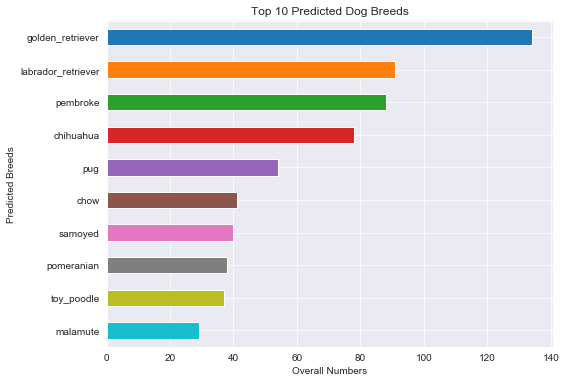

In [47]:
plt.figure(figsize=(8,6));
df_dog_breeds = df_clean.query('p1_dog == True')
df_dog_breeds.p1.value_counts()[0:10].plot(kind='barh');
plt.gca().invert_yaxis();  #fix the upside-down issue 
plt.xlabel('Overall Numbers')
plt.ylabel('Predicted Breeds')
plt.title('Top 10 Predicted Dog Breeds');

We will also check out the most popular dog names.

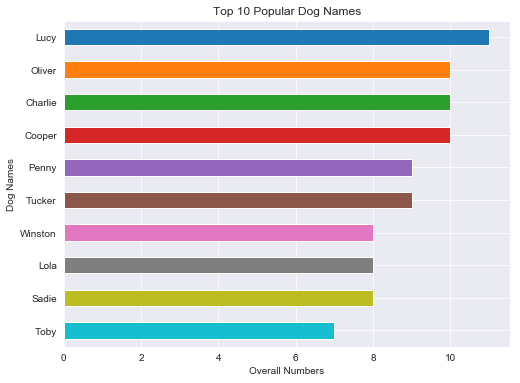

In [48]:
plt.figure(figsize=(8,6));
df_clean.name.value_counts()[0:10].plot(kind='barh');
plt.gca().invert_yaxis();
plt.xlabel('Overall Numbers')
plt.ylabel('Dog Names')
plt.title('Top 10 Popular Dog Names');

We can create a scatter plot of 'favorite_count', 'retweet_count' and visualize their linear fit line. 

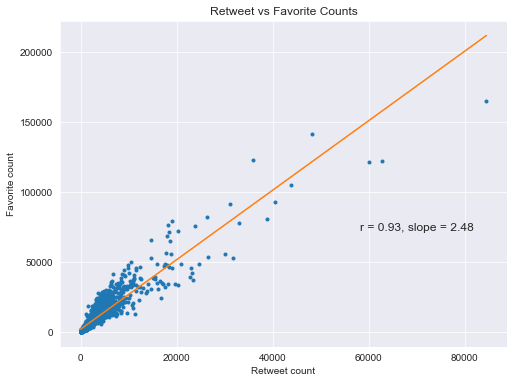

In [49]:
y = df_clean['favorite_count']
x = df_clean['retweet_count']

#generate linear fit line
xi = np.arange(0,df_clean['retweet_count'].max()+10)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope * xi + intercept

plt.figure(figsize=(8,6));
plt.plot(x, y, 'o',xi, line, markersize=3);
plt.text(70000, 75000,'r = {}, slope = {}'.format(np.around(r_value, 2), np.around(slope, 2)), horizontalalignment='center',
     verticalalignment='center', fontsize=12);
plt.xlabel('Retweet count')
plt.ylabel('Favorite count')
plt.title('Retweet vs Favorite Counts');

From the r-value we can tell 'favorite_count' and 'retweet_count' are strong correlated. For each tweet, the number of the favorites is about 3 times as the number of retweets.

We can also visualize the dog rating vs the favorite counts. Since we only keep the rating_denominator equals 10 or NaN, we can create a plot of rating_numerator and favorite_count.

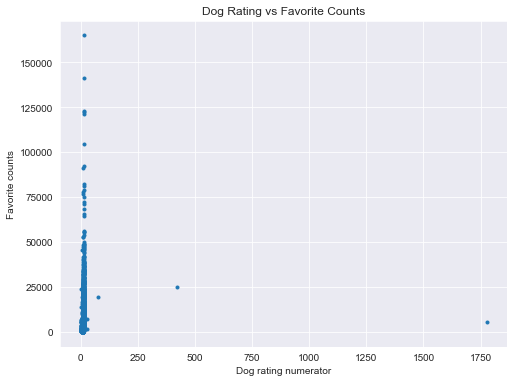

In [50]:
y = df_clean['favorite_count']
x = df_clean['rating_numerator']

plt.figure(figsize=(8,6));
plt.plot(x, y, 'o', markersize=3);
plt.xlabel('Dog rating numerator')
plt.ylabel('Favorite counts')
plt.title('Dog Rating vs Favorite Counts');

There are some outliers of rating_numerator. We will reset the x limits to remove those outliers from the plot.

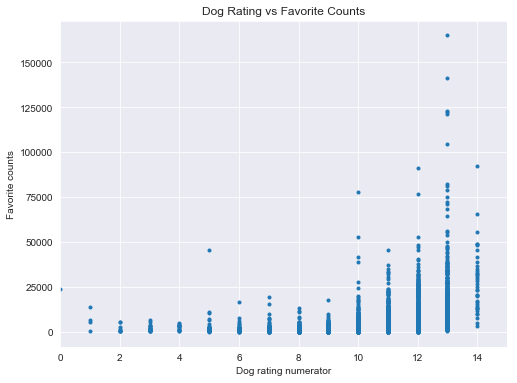

In [51]:
y = df_clean['favorite_count']
x = df_clean['rating_numerator']

plt.figure(figsize=(8,6));
plt.plot(x, y, 'o', markersize=3);
plt.xlabel('Dog rating numerator')
plt.ylabel('Favorite counts')
plt.title('Dog Rating vs Favorite Counts');
plt.xlim(0, 15);

We noticed from the plot that those tweets received many favorites also received relative high rating. 